# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

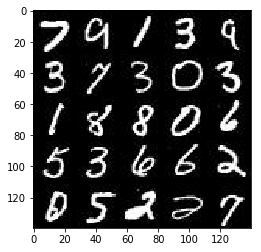

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

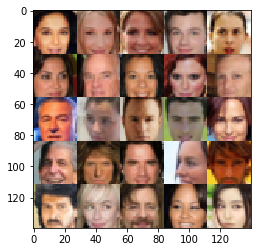

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9

    with tf.variable_scope('discriminator', reuse=reuse):
        L1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        L1 = tf.maximum(alpha * L1, L1)
        
        L2 = tf.layers.conv2d(L1, 128, 5, strides=2, padding='same', activation=None)
        L2 = tf.layers.batch_normalization(L2, training=True)
        L2 = tf.maximum(alpha * L2, L2)
        L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
        
        L3 = tf.layers.conv2d(L2, 256, 5, strides=2, padding='same', activation=None)
        L3 = tf.layers.batch_normalization(L3, training=True)
        L3 = tf.maximum(alpha * L3, L3)
        L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
        
        flat = tf.reshape(L3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 7x7x512
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        # 14x14x256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same', activation=None)
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        
        # 28x28x128        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same', activation=None)
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)   
        layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        
        # 28x28x5
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss       


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    steps = 0
    show_every = 100
    print_every = 10    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                                
                # Scale domain
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    g_train_loss = g_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7489... Generator Loss: 0.9071
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 1.4067
Epoch 1/2... Discriminator Loss: 1.8138... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.7942... Generator Loss: 1.0581
Epoch 1/2... Discriminator Loss: 1.7589... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 1.0792
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 1.2438


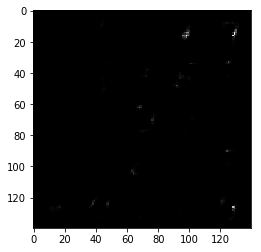

Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.9421
Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.8318... Generator Loss: 0.3459
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.6159... Generator Loss: 1.0290
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.5656
Epoch 1/2... Discriminator Loss: 1.6764... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.5805... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.8914


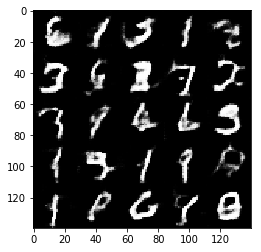

Epoch 1/2... Discriminator Loss: 1.6793... Generator Loss: 0.3730
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 1.4203
Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.5368... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.4713
Epoch 1/2... Discriminator Loss: 1.5769... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.6422... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 0.9872


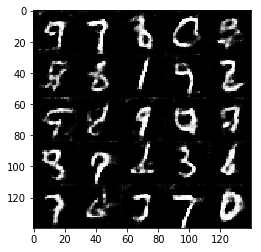

Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.5080... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.5383... Generator Loss: 1.2544
Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.5218
Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 0.5344


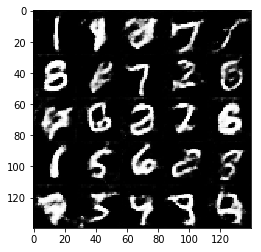

Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.4662... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 1.5671... Generator Loss: 0.4597
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.8483... Generator Loss: 0.2923


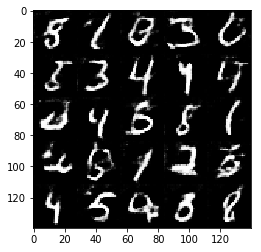

Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.5749... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.8765... Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 1.5688... Generator Loss: 0.4639
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.5439... Generator Loss: 0.5854
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.5881
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.6306


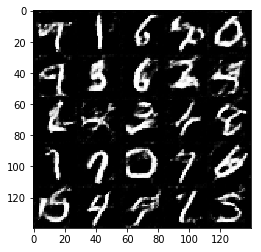

Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.4603
Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.8330... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.8394


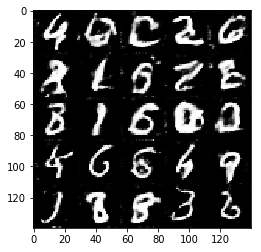

Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.4858
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 1.6034... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.5028... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 1.1013
Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.7315... Generator Loss: 0.3665


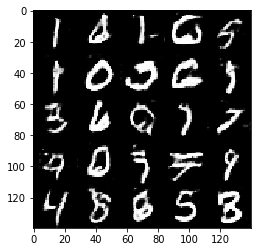

Epoch 1/2... Discriminator Loss: 1.7730... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.5902... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 1.3566
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.9139... Generator Loss: 0.2732


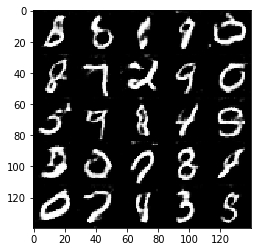

Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.9318
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.9211
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.5407... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.9959


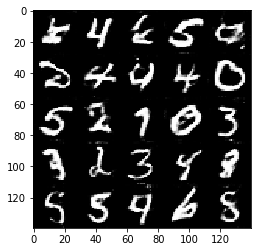

Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.7161... Generator Loss: 0.3623
Epoch 2/2... Discriminator Loss: 1.7918... Generator Loss: 0.3585
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 1.0372
Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 0.3873
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 1.5919... Generator Loss: 1.2034


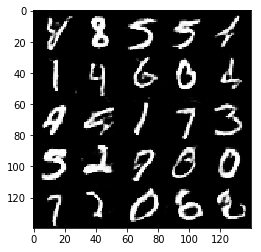

Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.6411... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 1.4272... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.5221... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 1.2346
Epoch 2/2... Discriminator Loss: 1.5277... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 1.2029


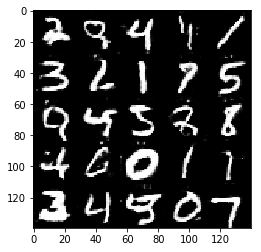

Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.6252... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 1.5226... Generator Loss: 0.5339
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4331
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.7627
Epoch 2/2... Discriminator Loss: 1.5944... Generator Loss: 0.4913
Epoch 2/2... Discriminator Loss: 1.5613... Generator Loss: 0.4547
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 1.2005


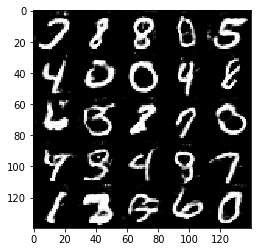

Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.5487
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.7022... Generator Loss: 0.4061
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.5761
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 1.4208
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.6934


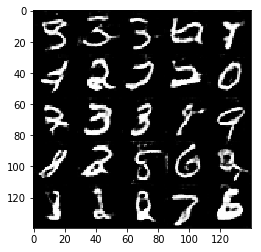

Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.9371
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.5651
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.6152
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 1.3193


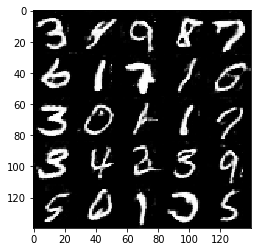

Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 1.4419... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 1.6053


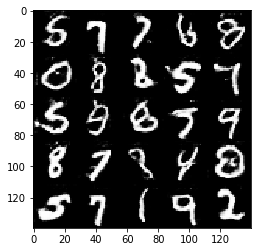

Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 1.2169
Epoch 2/2... Discriminator Loss: 1.7992... Generator Loss: 0.3308
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 2.1475
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.6193
Epoch 2/2... Discriminator Loss: 1.5660... Generator Loss: 0.4413
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.6050


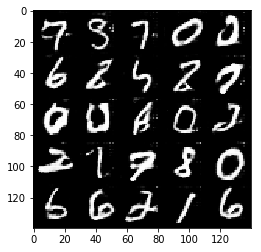

Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.4885
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 2.2151... Generator Loss: 0.2627
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 1.6102
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.5280... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.6988


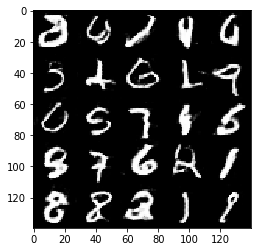

Epoch 2/2... Discriminator Loss: 1.6317... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 1.3141
Epoch 2/2... Discriminator Loss: 1.5175... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 2.0237... Generator Loss: 0.2815
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.6787


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0524... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.9591... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.3581
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.6484
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 2.2494
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.1795


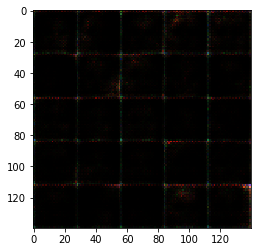

Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.9935
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.8331


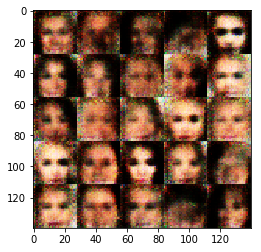

Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7621


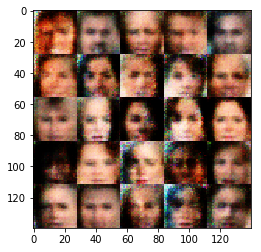

Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 1.2107
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.5936


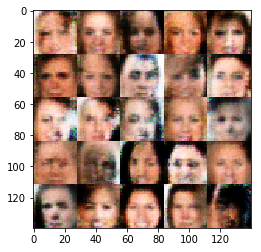

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.0874


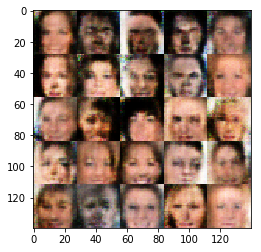

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 1.1832


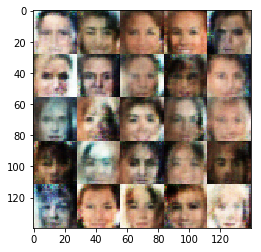

Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7579


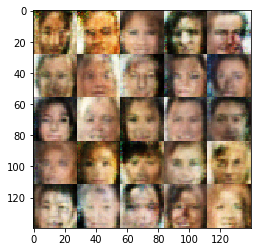

Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6886


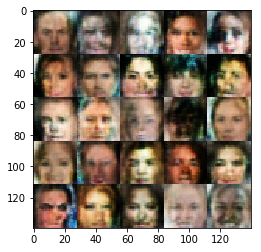

Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7507


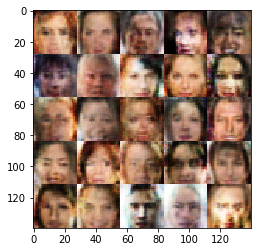

Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6661


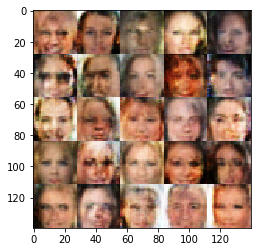

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7327


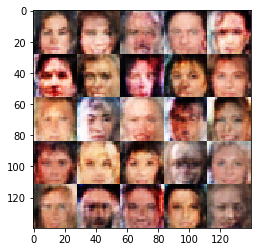

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6914


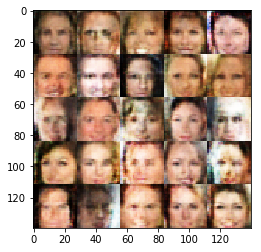

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7164


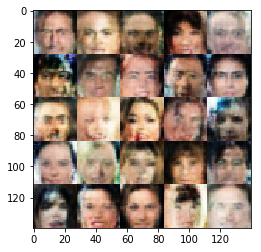

Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7160


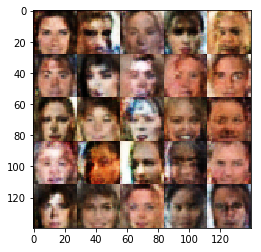

Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7172


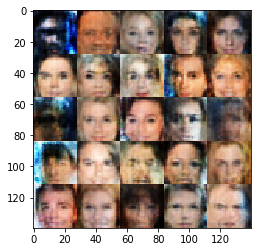

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.